# Simple FEM for one dimensional heat transfer problem

The problem for $T(t,x)$ is stated as
$$
\frac{\partial T}{\partial t} - \alpha \Delta T = 0 \quad \text{for} \quad x \in [0,L], t \in [0, Z]
$$
with a constant heat conductivity $\alpha$ subject to the boundary condition
$$
T(t, x=0) = 1
$$
and the initial condition
$$
T(t=0, x) = \cos(2\pi x)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nutils import function, mesh, solver
from nutils.expression_v2 import Namespace

from global_constants import L, Z, alpha

ns = Namespace()
ns.α = alpha

# Create topology (connectivity of mesh) and geometry (position of mesh)
N = 10
topo, geom = mesh.rectilinear([np.linspace(0, L, N)])

# Define the geometry variable as well as gradients, normal and jacobians on the domain.
ns.x = geom
ns.define_for("x", gradient="∇", normal="n", jacobians=("dV", "dS"))

## Prepare visualization
This code defines a python function `plot_line` to plot a *nutils* function (e.g. basis or solution variables) on the domain  $x \in [0, 1]$

In [2]:
bezier = topo.sample("bezier", 32)
nanjoin = lambda array, tri: np.insert(
    array.take(tri.flat, 0).astype(float),
    slice(tri.shape[1], tri.size, tri.shape[1]),
    np.nan,
    axis=0,
)
sampled_x = nanjoin(bezier.eval("x_0" @ ns), bezier.tri)


def plot_line(func, **arguments):
    plt.plot(sampled_x, nanjoin(bezier.eval(func, **arguments), bezier.tri))
    plt.xlabel("x_0")
    plt.xticks(np.linspace(0, L, 5))

## Basis
A *nutils* basis is a vector-based function that evalautes at any given point x on the domain to the array of basis functions.

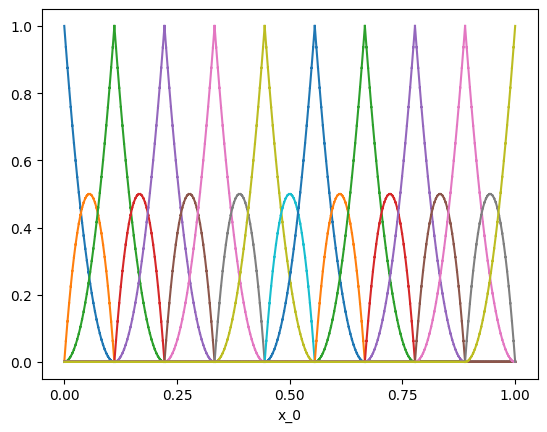

In [3]:
ns.basis = topo.basis("std", degree=2)
plot_line(ns.basis)

## Problem formulation

The weak form of the equation to be solved is 

$$ 
 \int_\Omega \frac{\partial T}{\partial t} v dV  + \int_\Omega \alpha \nabla T \cdot \nabla v dV = 0.
$$

The Dirichlet boundary condition at the left end is expressed as 

$$ 
 \underset{T}{\min} \int_{\partial\Omega_D} (T-1)^2 dS = 0.
$$

In [4]:
# The solution function to evaluate results is a dot product of the argument 'Th' with the basis)
ns.T = function.dotarg("lhs", ns.basis)

# By linearity the test function v can be replaced by the basis that spans its space.
residual = topo.integral("α ∇_i(basis_n) ∇_i(T) dV" @ ns, degree=2)

# By linearity the test function v can be replaced by the basis that spans its space.
inertia = topo.integral("T basis_n dV" @ ns, degree=2)

# Dirichlet boundary condition
sqr = topo.boundary["left"].integral("(T - 1)^2 dS" @ ns, degree=2)
constrain = solver.optimize("lhs", sqr, droptol=1e-15)

# Initial conditions
x0 = np.linspace(0, L, 2 * N - 1)
lhs0 = np.cos(2.0 * np.pi * x0)

# Solve the system
dt = 1e-4
lhsiter = iter(
    solver.cranknicolson(
        "lhs",
        residual=residual,
        inertia=inertia,
        timestep=dt,
        lhs0=lhs0,
        constrain=constrain,
    )
)

optimize > solve > solving 1 dof system to machine precision using arnoldi solver
optimize > solve > solver returned with residual 0e+00
optimize > constrained 1/19 dofs
optimize > optimum value 0.00e+00


## Integrate in time

newton > iter 1 (0%) > solve > solving 18 dof system to tolerance 7e-03 using arnoldi solver
newton > iter 1 (0%) > solve > solver returned with residual 3e-15
newton > iter 1 (0%) > estimated residual minimum at 100% of update vector
newton > iter 1 (0%) > update accepted at relaxation 1.0
newton > converged in 1 iterations to residual 1.3e-13
newton > iter 1 (0%) > solve > solving 18 dof system to tolerance 6e-03 using arnoldi solver
newton > iter 1 (0%) > solve > solver returned with residual 8e-16
newton > iter 1 (0%) > estimated residual minimum at 100% of update vector
newton > iter 1 (0%) > update accepted at relaxation 1.0
newton > converged in 1 iterations to residual 9.7e-14
newton > iter 1 (0%) > solve > solving 18 dof system to tolerance 6e-03 using arnoldi solver
newton > iter 1 (0%) > solve > solver returned with residual 2e-15
newton > iter 1 (0%) > estimated residual minimum at 100% of update vector
newton > iter 1 (0%) > update accepted at relaxation 1.0
newton > conve

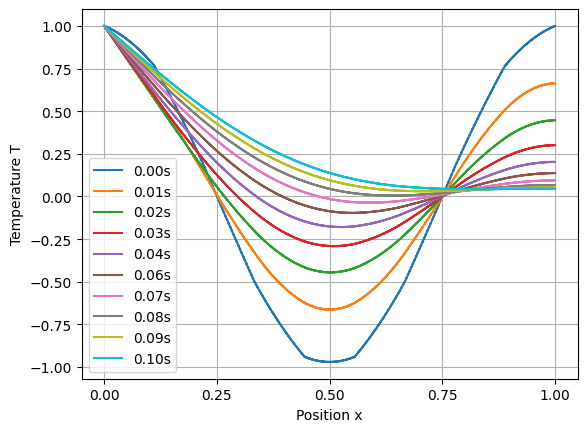

In [5]:
results = [lhs0]
for i in range(1, int(Z / dt)):
    res = next(lhsiter)
    if i % 100 == 0:
        results.append(res)

for res in results:
    plot_line(ns.T, lhs=res)
plt.legend([f"{t:.2f}s" for t in np.linspace(0, Z, 10)])
plt.xlabel("Position x")
plt.ylabel("Temperature T")
plt.grid()